In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.fft import fft,fftfreq
from scipy import signal
import librosa

from matplotlib import cm # for a scatter plot
from mpl_toolkits.mplot3d import Axes3D

### Utils

In [2]:
def plot_fft(y,fs):
    N=len(y)
    T = 1/fs
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]
    plt.figure(figsize=(14,4))
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    return

def butter_bandpass(lowcut, highcut, fs, order=12):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=12):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def analyze(str_filename,Clean_space):


    df_0 = pd.read_csv(Clean_space)
    df = pd.read_csv(str_filename)
    fs = 62500.0
    T = 1/fs
    N= df.shape[0]
    y = np.array(df.Audio) - np.array(df_0.Audio)
    t = np.arange(0,N)*T


    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]

    #Band Pass filtering
    
    lowcut = 15000.0
    highcut = 19000.0

    b, a = butter_bandpass(lowcut, highcut, fs, order=12)
    w, h = signal.freqz(b, a, worN=30000)

    y_filtered_sound = butter_bandpass_filter(y, lowcut, highcut, fs, order=12)

    yf_filtered = fft(y_filtered_sound)
    xf_filtered = fftfreq(N, T)[:N//2]

    # Plot the frequency response and waveforms
    fig,ax = plt.subplots(4,1, figsize=(16,16))
    ax[0].plot(t, y)
    ax[0].title.set_text('Recieved Echo')

    ax[1].plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    ax[1].title.set_text('FFT of the Recieved Echo')

    ax[2].plot(t, y_filtered_sound)
    ax[2].title.set_text('BandPass filtered Recieved Echo')

    ax[3].plot(xf_filtered, 2.0/N * np.abs(yf_filtered[0:N//2]))
    ax[3].set_xlim((10000,22000))
    ax[3].title.set_text('FFT of BP-Recieved Echo')

    plt.show()

def butter_lowpass(cutoff, fs , order=4):
    nyq_freq = fs/2
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y  

def extract_peak_frequency(data, sampling_rate):
    fft_data = np.fft.fft(data)
    freqs = np.fft.fftfreq(len(data))
    
    peak_coefficient = np.argmax(np.abs(fft_data))
    peak_freq = freqs[peak_coefficient]
    
    return abs(peak_freq * sampling_rate)

def Phase_lag_Hilbert(x1,x2,sampling_rate):
    
    x1h = signal.hilbert(x1)
    x2h = signal.hilbert(x2)
    omega = (extract_peak_frequency(x1,sampling_rate) + extract_peak_frequency(x2,sampling_rate))/2
             
    c = np.inner( x1h, np.conj(x2h) ) / np.sqrt( np.inner(x1h,np.conj(x1h)) * np.inner(x2h,np.conj(x2h)) )
    phase_diff = np.angle(c)/(np.pi*2*omega)
    return(-phase_diff * sampling_rate) # return the delayed number of sample points


def Phase_lag_xcc(A,B,sampling_rate):
    
    # Find cross-correlation
    xcorr = signal.correlate(A, B)
    lags = signal.correlation_lags(len(A), len(B))
    # delta time array to match xcorr
    omega = (extract_peak_frequency(A,sampling_rate) + extract_peak_frequency(B,sampling_rate))/2

    recovered_time_shift = lags[np.argmax(xcorr)]

    return(recovered_time_shift*(1/1000)*(np.pi*2*omega))

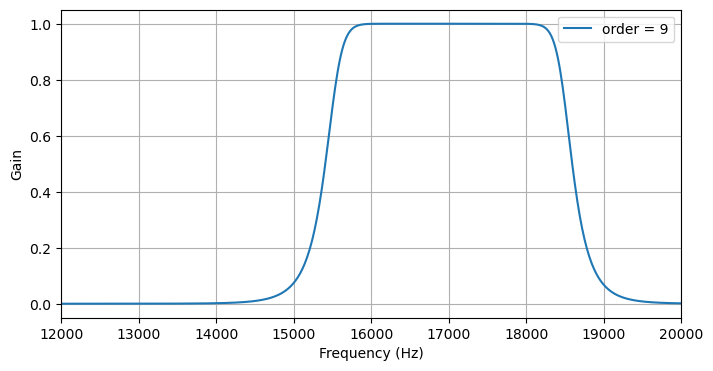

In [3]:
fs = 62500.0
lowcut =15500.0
highcut = 18500.0

# Plot the frequency response for a few different orders.
plt.figure(figsize=(8,4))
plt.clf()
for order in [ 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = scipy.signal.freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)
    plt.xlabel('Frequency (Hz)')
    plt.xlim((12000,20000))
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

### Transmitted Signal (Ideal)

In [4]:
def Chirp(ti):
    multiplier = (int(ti*1000)%200)//10
    freq = 16000 + 125*multiplier
    if(multiplier%2 or multiplier>17):
        return(0.0)
    else:
        #return(freq)
        return (np.sin(2*np.pi*freq*(ti)))


In [5]:
a=np.zeros(7)
b= np.ones(2)
np.concatenate((a,b))

array([0., 0., 0., 0., 0., 0., 0., 1., 1.])

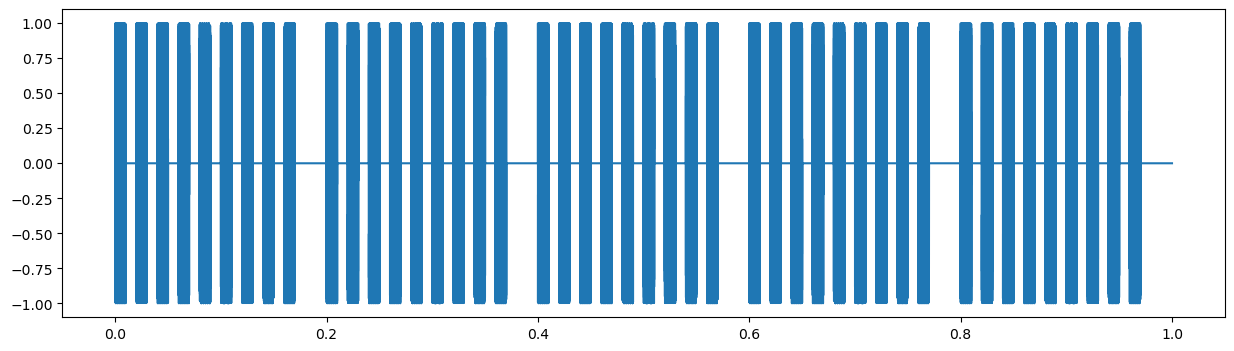

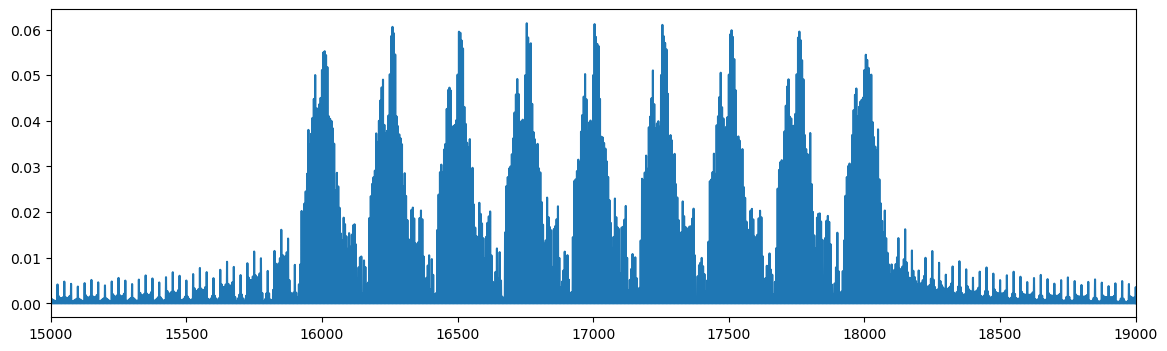

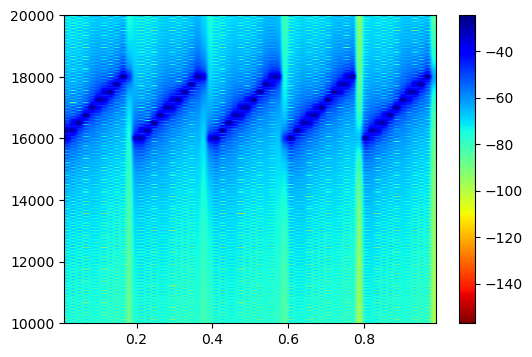

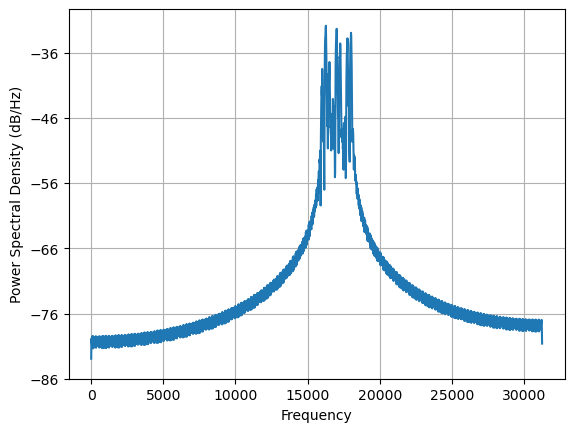

In [6]:

time = np.linspace(0, 1, 62500, False)  # 1 second
transmitted_signal = np.array([Chirp(t_t) for t_t in time])

plt.figure(figsize=(15,4))
plt.plot(time,transmitted_signal)

yf_tranmit = fft(transmitted_signal)
plot_fft(transmitted_signal,62500)
plt.xlim((15000,19000))

fs = 62500
plt.figure(figsize=(6,4))
plt.specgram(transmitted_signal,NFFT=2048,Fs=fs,noverlap=1024,cmap="jet_r")
plt.ylim((10000,20000))

plt.colorbar()
plt.show()

plt.psd(transmitted_signal,NFFT=4096,Fs=fs)
plt.show()

### Echo Analyzing

In [7]:
# upload the data
clean_space = "16KHz-18KHz\Clean Space\Measurement_3.csv"
str_filename_1 = "16KHz-18KHz\Relax State\Measurement_R.csv"   
str_filename_2 = "16KHz-18KHz\Relax State\Measurement_10.csv" 

str_filename_3 = "16KHz-18KHz\Open Mouth\Measurement_R.csv"   
str_filename_4 = "16KHz-18KHz\Open Mouth\Measurement_10.csv"

str_filename_5 = "16KHz-18KHz\Blow\Measurement_R.csv"   
str_filename_6 = "16KHz-18KHz\Blow\Measurement_10.csv"
#analyze(str_filename,Clean_space)  

df_0 = pd.read_csv(clean_space)
df = pd.read_csv(str_filename_1)
df_2 = pd.read_csv(str_filename_3)

In [8]:
def minmax_normalize(data_set):
    data_normalized = (data_set-np.min(data_set))/(np.max(data_set)-np.min(data_set))
    return data_normalized

def standardize(data_set):
    data_normalize = (data_set-np.mean(data_set))/np.std(data_set)
    return data_normalize


In [9]:
clean_wave = (np.array(df_0.Audio))

relax_wave_1= standardize((np.array(pd.read_csv(str_filename_1).Audio)).astype(float))
relax_wave_2= standardize((np.array(pd.read_csv(str_filename_2).Audio)).astype(float))

OpenMouth_wave_1= standardize((np.array(pd.read_csv(str_filename_3).Audio)).astype(float))
OpenMouth_wave_2= standardize((np.array(pd.read_csv(str_filename_4).Audio)).astype(float))

blow_wave_1= standardize((np.array(pd.read_csv(str_filename_5).Audio)).astype(float))
blow_wave_2= standardize((np.array(pd.read_csv(str_filename_6).Audio)).astype(float))

clean_wave = standardize(clean_wave.astype(float))

(0.0, 0.05)

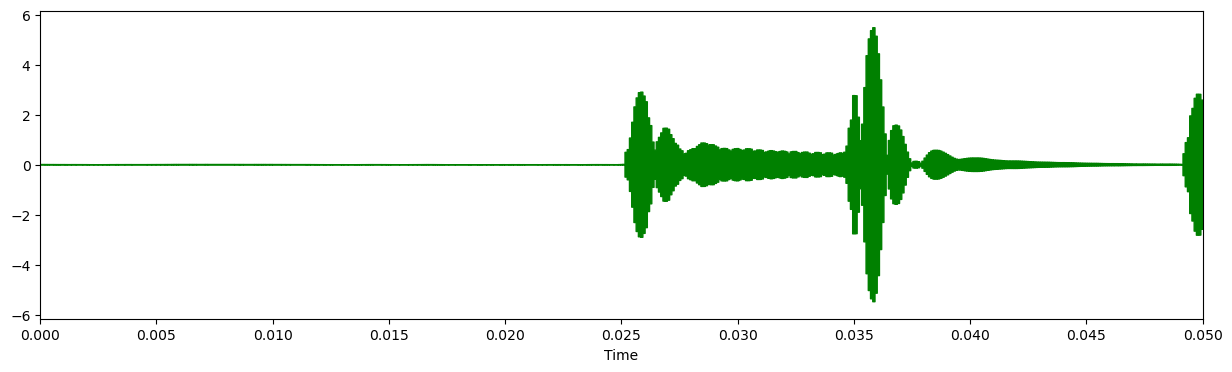

In [10]:
plt.figure(figsize=(15,4))
librosa.display.waveshow(clean_wave,sr=fs,color="green")
plt.xlim((0.0,0.05))

In [11]:
np.where(clean_wave>0.1)[0][0]

1581

(0.0, 0.05)

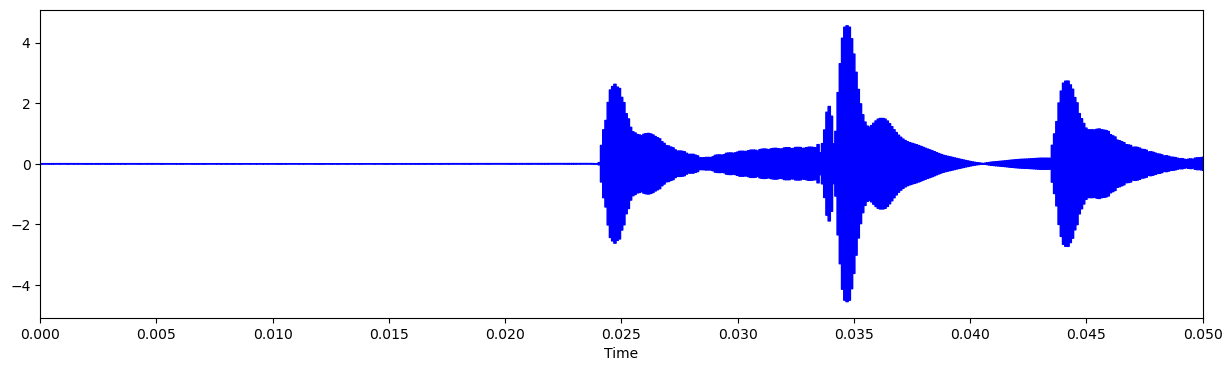

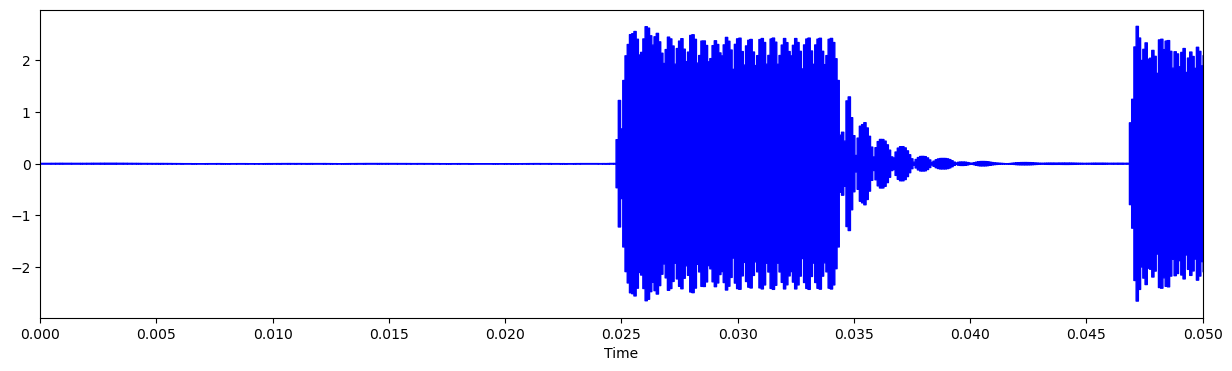

In [12]:
plt.figure(figsize=(15,4))
librosa.display.waveshow(relax_wave_1,sr=fs,color="blue")
plt.xlim((0.0,0.05))
plt.figure(figsize=(15,4))
librosa.display.waveshow(relax_wave_2,sr=fs,color="blue")
plt.xlim((0.0,0.05))

#plt.ylim((-500,500))
#plt.show()

(0.0, 0.05)

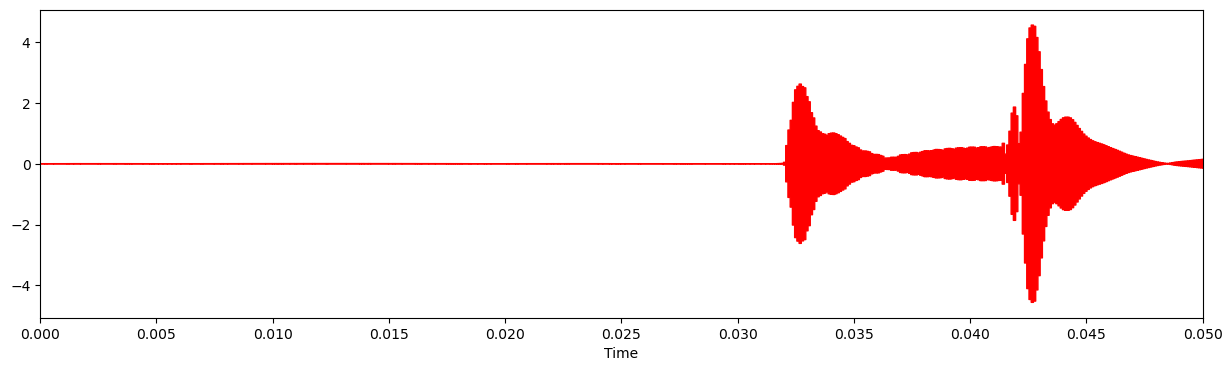

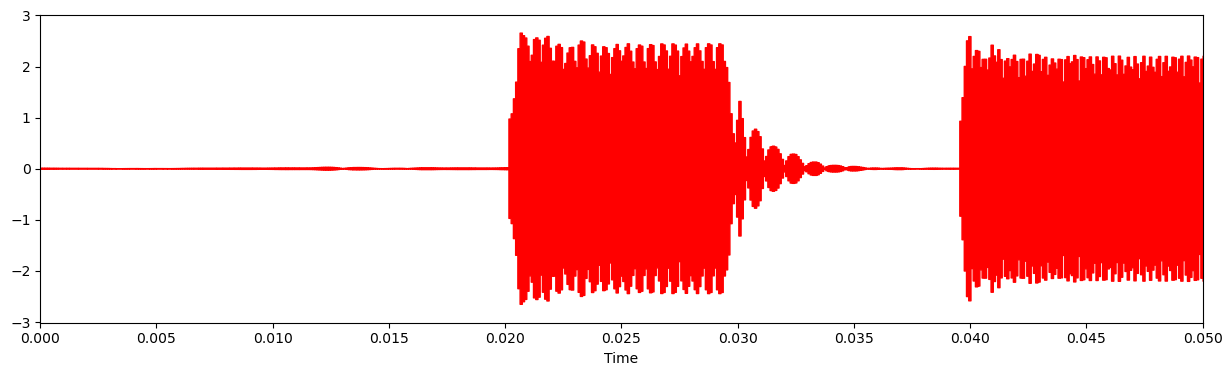

In [13]:
plt.figure(figsize=(15,4))
librosa.display.waveshow(OpenMouth_wave_1,sr=fs,color="red")
plt.xlim((0.0,0.05))
plt.figure(figsize=(15,4))
librosa.display.waveshow(OpenMouth_wave_2,sr=fs,color="red")
plt.xlim((0.0,0.05))
#plt.ylim((-500,500))
#plt.show()

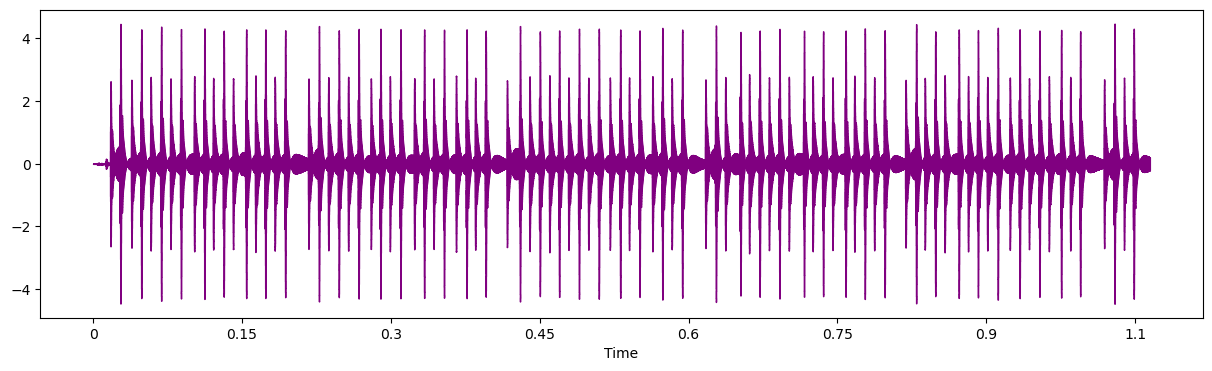

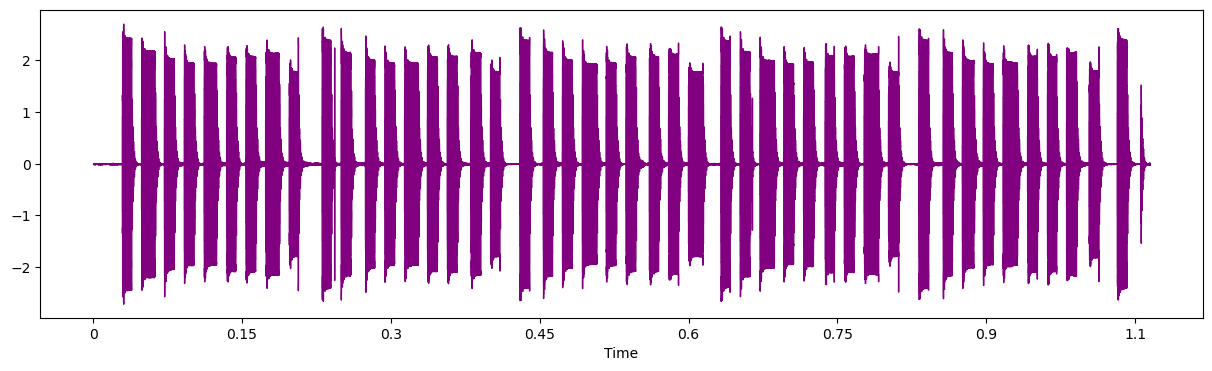

In [14]:
plt.figure(figsize=(15,4))
librosa.display.waveshow(blow_wave_1,sr=fs,color="purple")
#plt.xlim((0.0,0.05))

plt.figure(figsize=(15,4))
librosa.display.waveshow(blow_wave_2,sr=fs,color="purple")
#plt.xlim((0.0,0.05))

Need remove the phase diffarace 

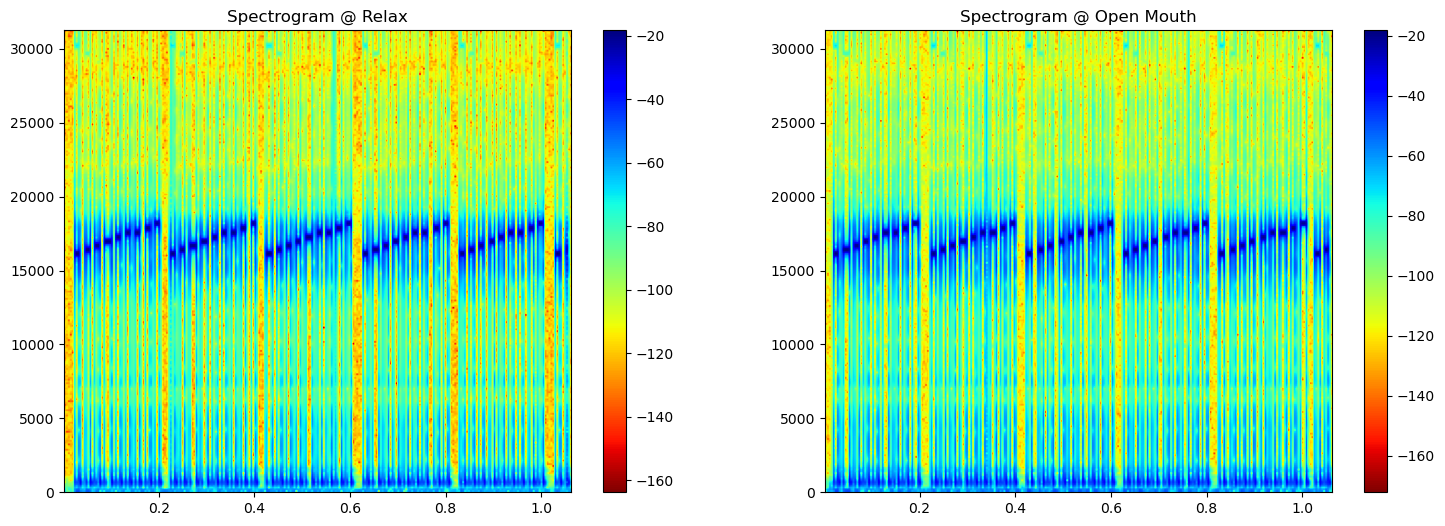

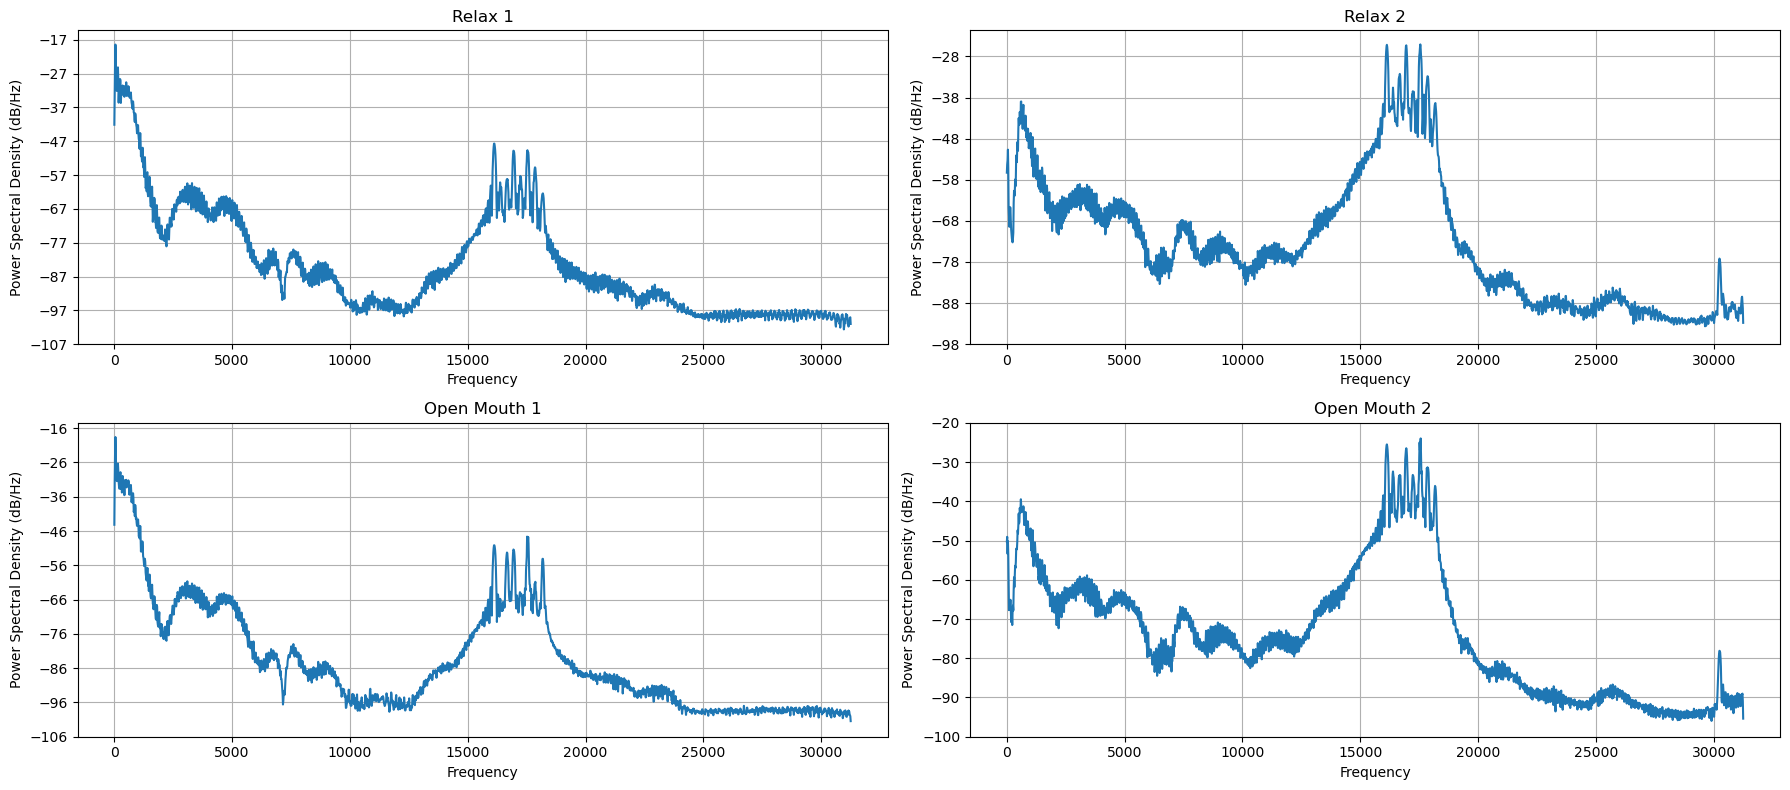

In [15]:
plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)
plt.specgram(relax_wave_2,NFFT=512,Fs=fs,noverlap=256,cmap="jet_r")

plt.title("Spectrogram @ Relax")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.specgram(OpenMouth_wave_2,NFFT=512,Fs=fs,noverlap=256,cmap="jet_r")
plt.title("Spectrogram @ Open Mouth")
plt.colorbar()

plt.show()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))

# plot time signal:
axs[0, 0].set_title("Relax 1")
axs[0, 0].psd(relax_wave_1,NFFT=4096,Fs=fs)


# plot different spectrum types:
axs[0, 1].set_title("Relax 2")
axs[0, 1].psd(relax_wave_2,NFFT=4096,Fs=fs)

axs[1, 0].set_title("Open Mouth 1")
axs[1, 0].psd(OpenMouth_wave_1,NFFT=4096,Fs=fs)

axs[1, 1].set_title("Open Mouth 2 ")
axs[1, 1].psd(OpenMouth_wave_2,NFFT=4096,Fs=fs)


fig.tight_layout()
plt.show()

In [16]:

fs = 62500
T = 1/fs
N= df.shape[0]
t = np.arange(0,N)*T

### Additionally Averging (per chirp)

In [17]:
def Additionally_average(data_set,fs):
    fs = int(fs)
    tau = np.where(data_set>0.1)[0][0]
    
    averaged_data = data_set[tau : int(0.2*fs)+tau]

    for i in range(1,5):
        
        averaged_data= averaged_data + data_set[int(0.2*i*fs) +tau : int(0.2*(i+1)*fs) +tau]
        averaged_data = (averaged_data.astype(float))/4
    return(averaged_data)

In [18]:
standardize

<function __main__.standardize(data_set)>

In [19]:
avg_clean_wave = standardize(Additionally_average(clean_wave,fs))
avg_transmit_wave = transmitted_signal[:int(0.2*fs)]

avg_relax_wave_1 = standardize(Additionally_average(relax_wave_1,fs))
avg_relax_wave_2 = standardize(Additionally_average(relax_wave_2,fs))

avg_OpenMouth_wave_1 = standardize(Additionally_average(OpenMouth_wave_1,fs))
avg_OpenMouth_wave_2 = standardize(Additionally_average(OpenMouth_wave_2,fs))

avg_blow_wave_1 = standardize(Additionally_average(blow_wave_1,fs))
avg_blow_wave_2 = standardize(Additionally_average(blow_wave_2,fs))

## Filtering through the bandpass filter

In [20]:
Lcut=16000
Hcut = 18000

In [21]:
avg_clean_wave = butter_bandpass_filter(avg_clean_wave,Lcut,Hcut,fs=62500)

avg_relax_wave_1 = (butter_bandpass_filter(avg_relax_wave_1,Lcut,Hcut,fs=62500))
avg_relax_wave_2 = butter_bandpass_filter(avg_relax_wave_2,Lcut,Hcut,fs=62500)

avg_OpenMouth_wave_1 = butter_bandpass_filter(avg_OpenMouth_wave_1,Lcut,Hcut,fs=62500)
avg_OpenMouth_wave_2 = butter_bandpass_filter(avg_OpenMouth_wave_2,Lcut,Hcut,fs=62500)

avg_blow_wave_1 = butter_bandpass_filter(avg_blow_wave_1,Lcut,Hcut,fs=62500)
avg_blow_wave_2 = butter_bandpass_filter(avg_blow_wave_2,Lcut,Hcut,fs=62500)

avg_transmit_wave = butter_bandpass_filter(avg_transmit_wave,Lcut,Hcut,fs=62500)

(0.0, 0.2)

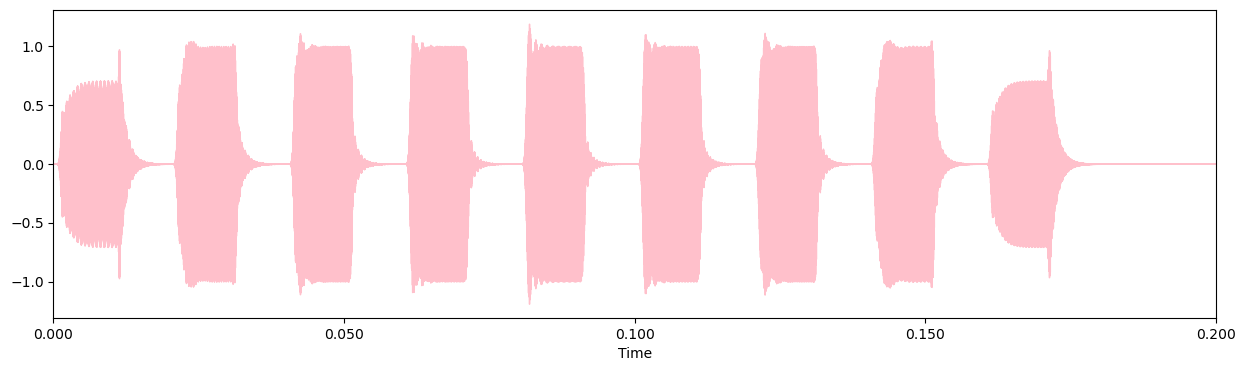

In [22]:
plt.figure(figsize=(15,4))
librosa.display.waveshow(avg_transmit_wave,sr=fs,color="pink")
plt.xlim((0,0.2))

(0.0, 0.2)

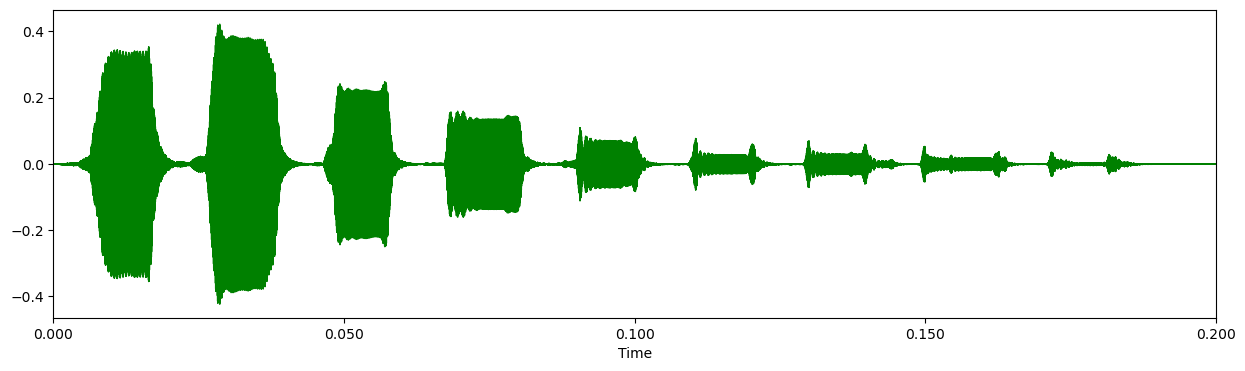

In [23]:
plt.figure(figsize=(15,4))
librosa.display.waveshow(avg_clean_wave,sr=fs,color="green")
plt.xlim((0,0.2))

(0.0, 0.2)

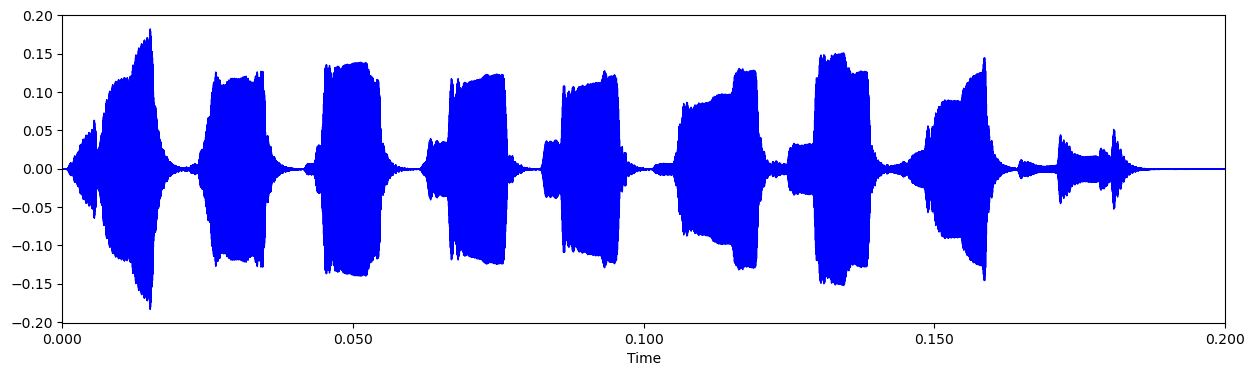

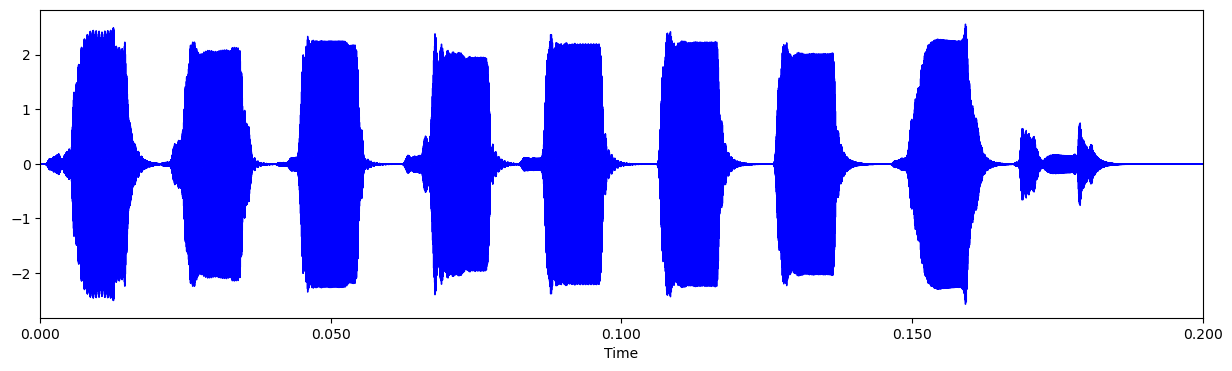

In [24]:
plt.figure(figsize=(15,4))
librosa.display.waveshow(avg_relax_wave_1,sr=fs,color="blue")
plt.xlim((0,0.2))

plt.figure(figsize=(15,4))
librosa.display.waveshow(avg_relax_wave_2,sr=fs,color="blue")
plt.xlim((0.0,0.2))


(0.0, 0.2)

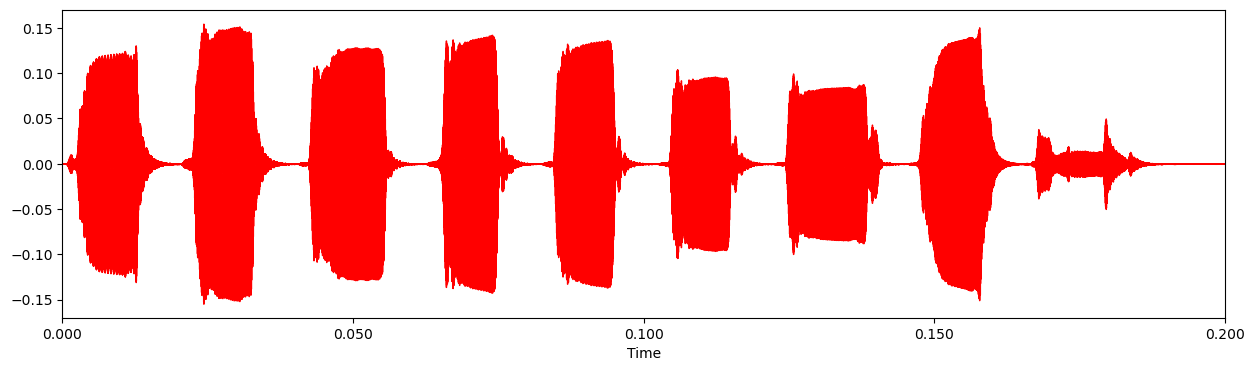

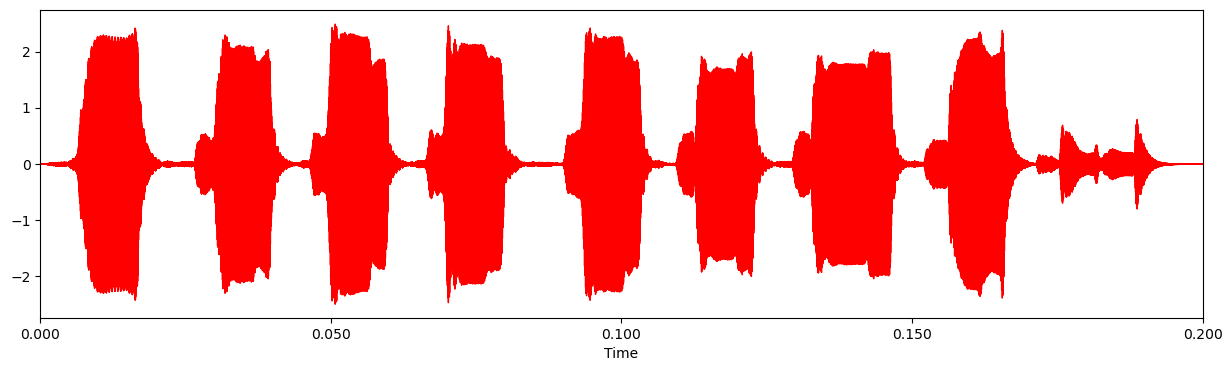

In [25]:
plt.figure(figsize=(15,4))
librosa.display.waveshow(avg_OpenMouth_wave_1,sr=fs,color="red")
plt.xlim((0.0,0.2))

plt.figure(figsize=(15,4))
librosa.display.waveshow(avg_OpenMouth_wave_2,sr=fs,color="red")
plt.xlim((0.0,0.2))


(0.0, 0.2)

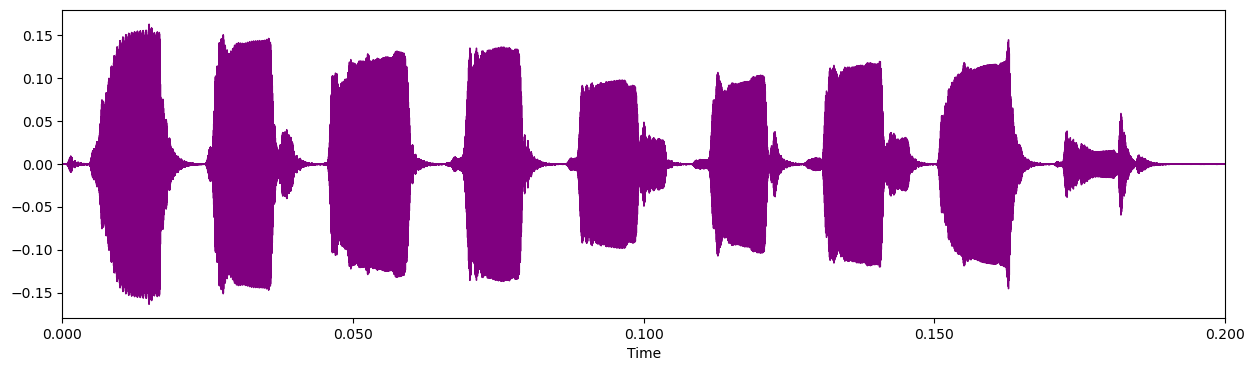

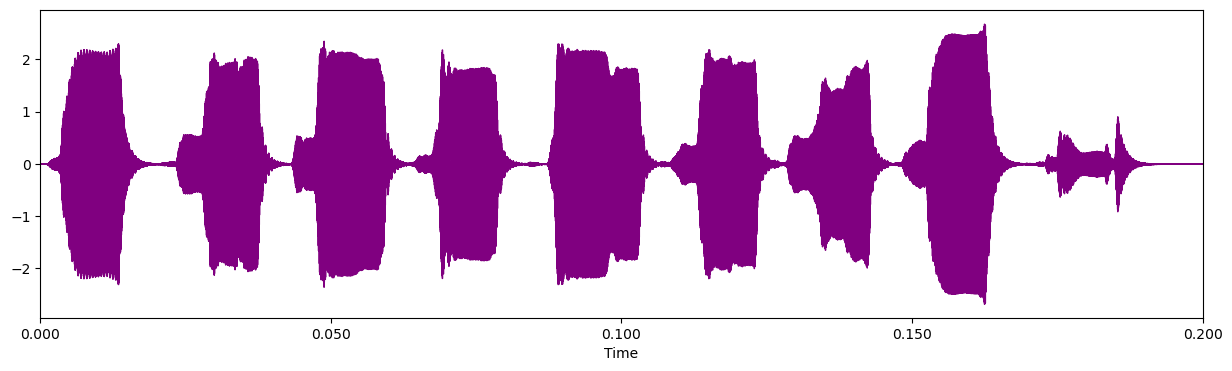

In [26]:
plt.figure(figsize=(15,4))
librosa.display.waveshow(avg_blow_wave_1,sr=fs,color="purple")
plt.xlim((0.0,0.2))

plt.figure(figsize=(15,4))
librosa.display.waveshow(avg_blow_wave_2,sr=fs,color="purple")
plt.xlim((0.0,0.2))

## TF modeling

In [27]:
fs = 62500
T = 1/fs
N= len(avg_clean_wave)
t = np.arange(0,N)*T

In [28]:
yf_transmit = fft(transmitted_signal[:N])
yf_clean = fft(avg_clean_wave)

yf_relax_1,yf_relax_2 = fft(avg_relax_wave_1),fft(avg_relax_wave_2)
yf_opM_1,yf_opM_2 = fft(avg_OpenMouth_wave_1),fft(avg_OpenMouth_wave_2)
yf_blow_1,yf_blow_2 = fft(avg_blow_wave_1),fft(avg_blow_wave_2)

X_f = fftfreq(N,T)
xf = fftfreq(N, T)[:N//2]


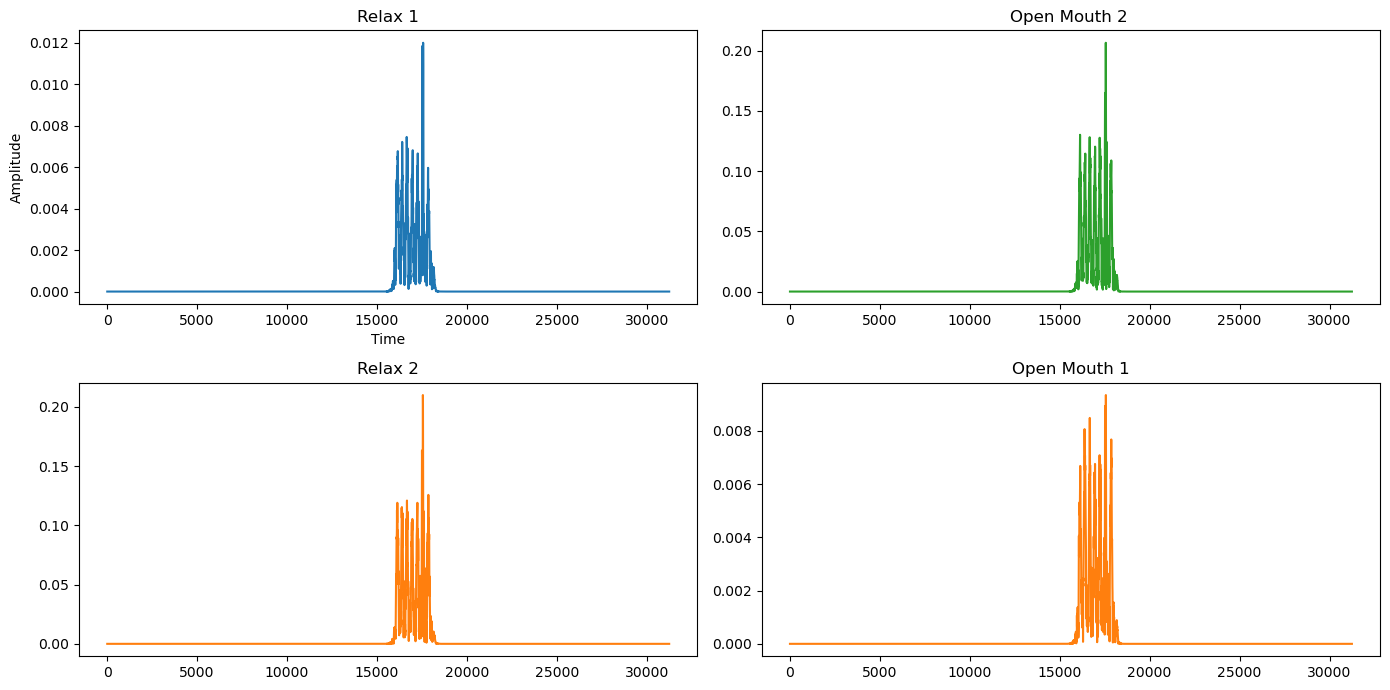

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 7))

# plot time signal:
axs[0, 0].set_title("Relax 1")
axs[0, 0].plot(xf, 2.0/N * np.abs(yf_relax_1[0:N//2]), color='C0')
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("Amplitude")

# plot different spectrum types:
axs[1, 0].set_title("Relax 2")
axs[1, 0].plot(xf, 2.0/N * np.abs(yf_relax_2[0:N//2]), color='C1')

axs[1, 1].set_title("Open Mouth 1")
axs[1, 1].plot(xf, 2.0/N * np.abs(yf_opM_1[0:N//2]), color='C1')

axs[0, 1].set_title("Open Mouth 2 ")
axs[0, 1].plot(xf, 2.0/N * np.abs(yf_opM_2[0:N//2]), color='C2')


fig.tight_layout()
plt.show()

In [30]:
trans_relax_1 = (yf_relax_1- yf_clean)/yf_transmit
trans_relax_2 = (yf_relax_2- yf_clean)/yf_transmit

trans_openMouth_1 = (yf_opM_1 - yf_clean)/yf_transmit
trans_openMouth_2 = (yf_opM_2 - yf_clean)/yf_transmit

trans_blow_1 = (yf_blow_1 - yf_clean)/yf_transmit
trans_blow_2 = (yf_blow_2- yf_clean)/yf_transmit

Text(0.5, 0, 'Frequency')

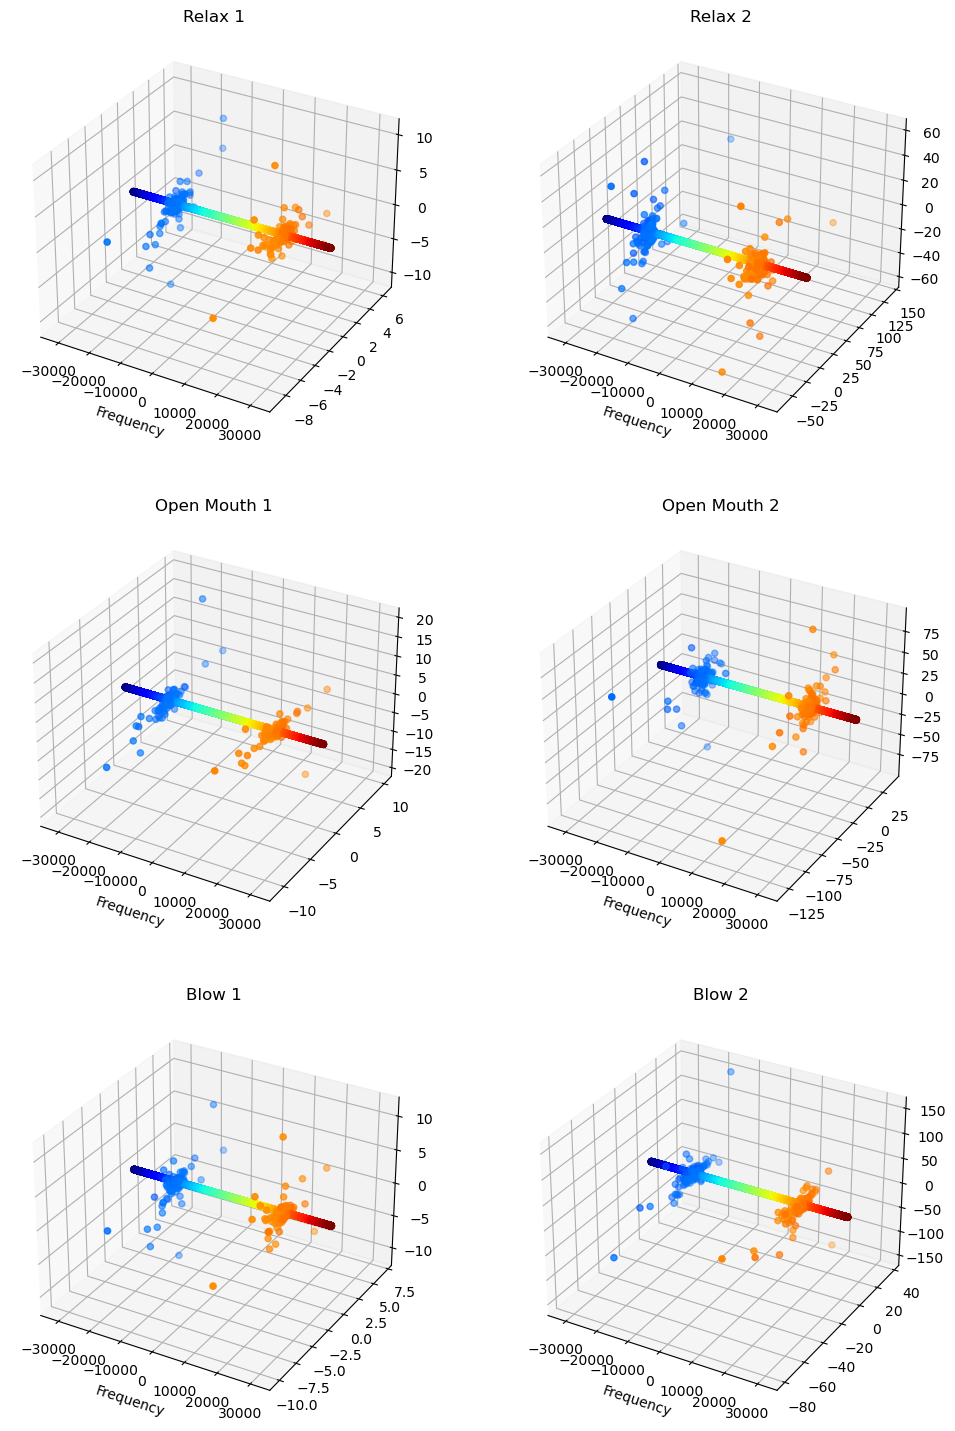

In [31]:
fig, ax = plt.subplots(3,2,figsize=(12,18),subplot_kw=dict(projection='3d'))

sc1 = ax[1,0].scatter(X_f,np.real(trans_openMouth_1),np.imag(trans_openMouth_1), c=X_f, cmap=cm.jet)
ax[1,0].set_title('Open Mouth 1')
ax[1,0].set_xlabel("Frequency")


sc2 = ax[0,0].scatter(X_f ,np.real(trans_relax_1),np.imag(trans_relax_1),c=X_f, cmap=cm.jet)
ax[0,0].set_title('Relax 1')
ax[0,0].set_xlabel("Frequency")

sc3 = ax[1,1].scatter(X_f,np.real(trans_openMouth_2),np.imag(trans_openMouth_2), c=X_f, cmap=cm.jet)
ax[1,1].set_title('Open Mouth 2')
ax[1,1].set_xlabel("Frequency")

sc4 = ax[0,1].scatter(X_f ,np.real(trans_relax_2),np.imag(trans_relax_2),c=X_f, cmap=cm.jet)
ax[0,1].set_title('Relax 2')
ax[0,1].set_xlabel("Frequency")

sc5 = ax[2,0].scatter(X_f,np.real(trans_blow_1),np.imag(trans_blow_1), c=X_f, cmap=cm.jet)
ax[2,0].set_title('Blow 1')
ax[2,0].set_xlabel("Frequency")

sc6 = ax[2,1].scatter(X_f ,np.real(trans_blow_2),np.imag(trans_blow_2),c=X_f, cmap=cm.jet)
ax[2,1].set_title('Blow 2')
ax[2,1].set_xlabel("Frequency")



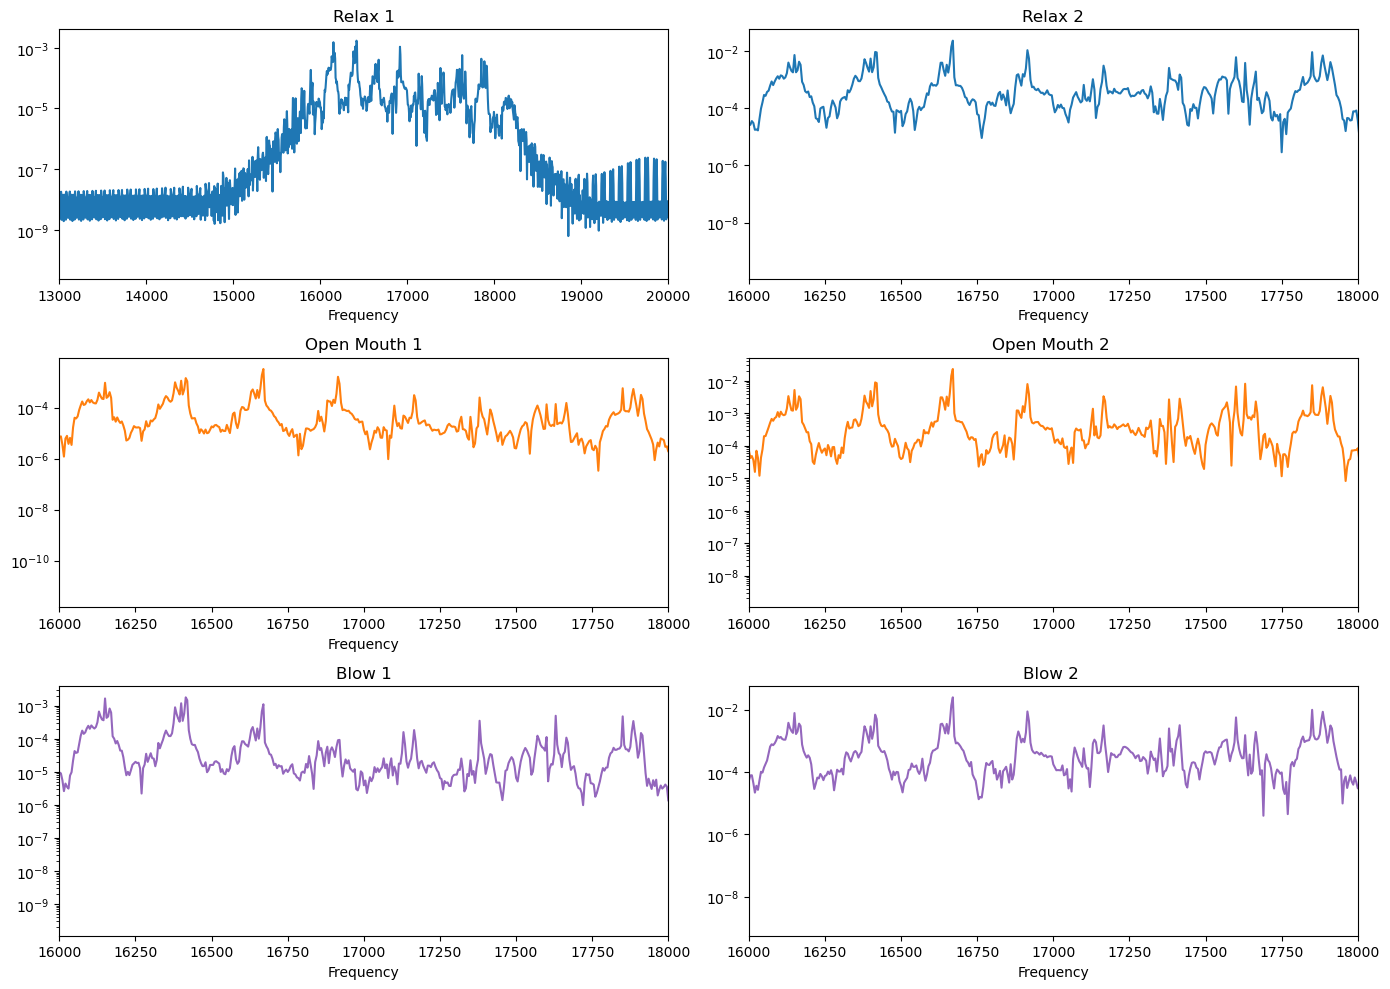

In [43]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))

# plot time signal:
axs[0, 0].set_title("Relax 1")
axs[0, 0].semilogy(xf, 2.0/N * np.abs((trans_relax_1)[0:N//2]), color='C0')
axs[0, 0].set_xlim((16000,28000))
axs[0, 0].set_xlabel("Frequency")


# plot different spectrum types:
axs[0,1].set_title("Relax 2")
axs[0,1].semilogy(xf, 2.0/N * np.abs((trans_relax_2)[0:N//2]), color='C0')
axs[0, 1].set_xlim((16000,18000))
axs[0, 1].set_xlabel("Frequency")

axs[1, 0].set_title("Open Mouth 1")
axs[1, 0].semilogy(xf, 2.0/N * np.abs((trans_openMouth_1)[0:N//2]), color='C1')
axs[1, 0].set_xlim((16000,18000))
axs[1, 0].set_xlabel("Frequency")

axs[1, 1].set_title("Open Mouth 2 ")
axs[1, 1].semilogy(xf, 2.0/N * np.abs((trans_openMouth_2)[0:N//2]), color='C1')
axs[1, 1].set_xlim((16000,18000))
axs[1, 0].set_xlabel("Frequency")

axs[2, 0].set_title("Blow 1")
axs[2, 0].semilogy(xf, 2.0/N * np.abs((trans_blow_1)[0:N//2]), color='C4')
axs[2, 0].set_xlim((16000,18000))
axs[2, 0].set_xlabel("Frequency")


axs[2, 1].set_title("Blow 2 ")
axs[2, 1].semilogy(xf, 2.0/N * np.abs((trans_blow_2)[0:N//2]), color='C4')
axs[2, 1].set_xlim((16000,18000))
axs[2, 1].set_xlabel("Frequency")

fig.tight_layout()
plt.show()

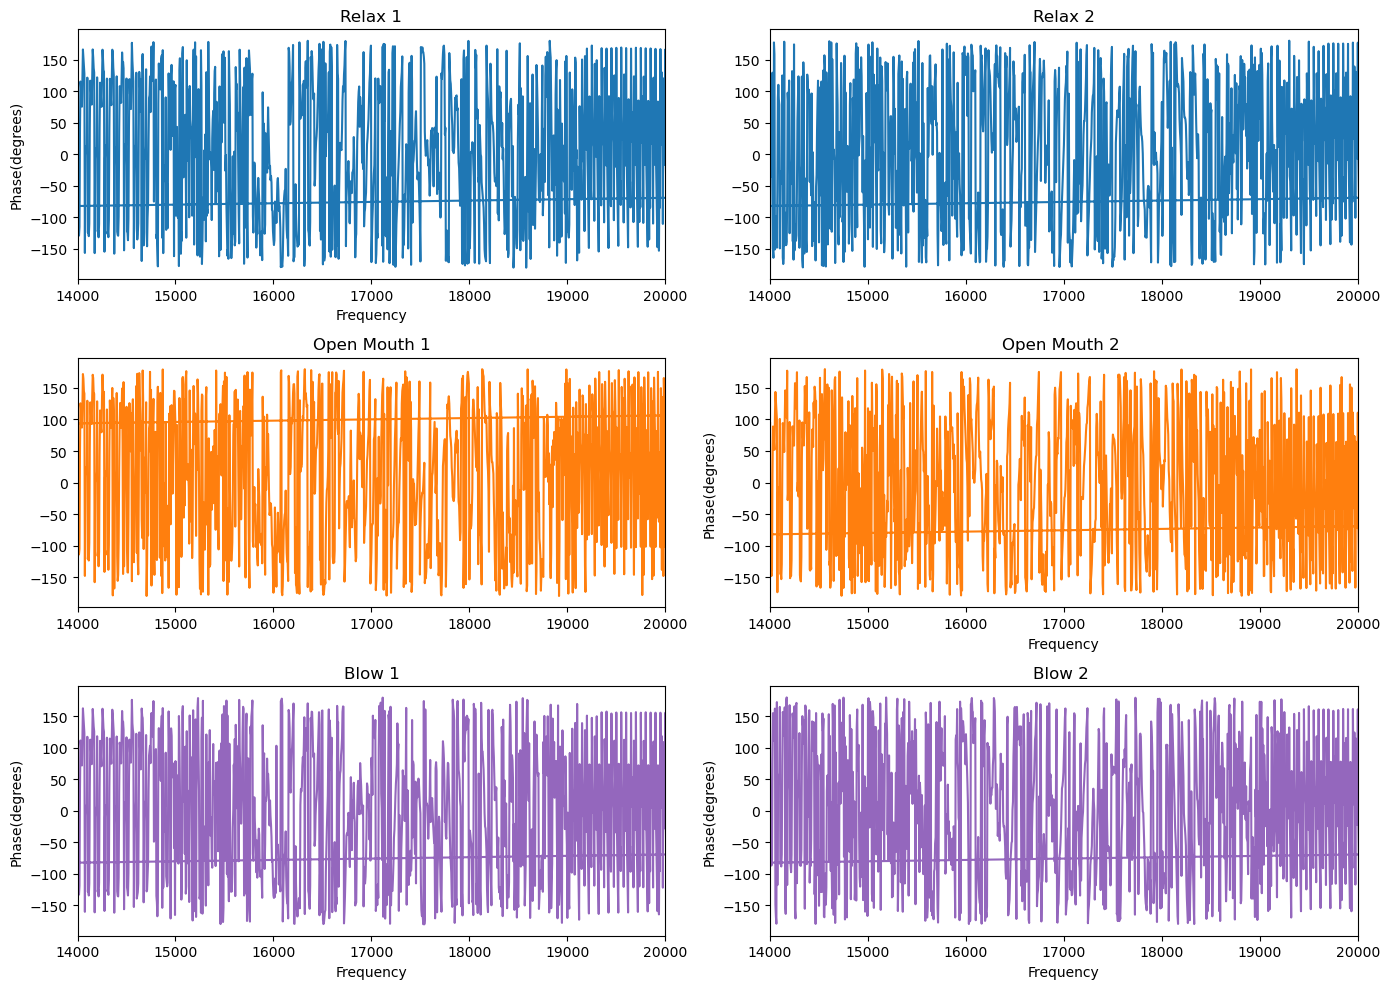

In [46]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))

# plot time signal:
axs[0, 0].set_title("Relax 1")
axs[0, 0].plot(X_f, np.angle((trans_relax_1))*(180/np.pi), color='C0')
axs[0, 0].set_xlim((14000,20000))
axs[0, 0].set_xlabel("Frequency")
axs[0, 0].set_ylabel("Phase(degrees)")

# plot different spectrum types:
axs[0,1].set_title("Relax 2")
axs[0,1].plot(X_f, np.angle((trans_relax_2))*(180/np.pi), color='C0')
axs[0, 1].set_xlim((14000,20000))
axs[0, 0].set_xlabel("Frequency")
axs[0, 0].set_ylabel("Phase(degrees)")

axs[1, 0].set_title("Open Mouth 1")
axs[1, 0].plot(X_f, np.angle((trans_openMouth_1))*(180/np.pi), color='C1')
axs[1, 0].set_xlim((14000,20000))
axs[0, 0].set_xlabel("Frequency")
axs[0, 0].set_ylabel("Phase(degrees)")

axs[1, 1].set_title("Open Mouth 2 ")
axs[1, 1].plot(X_f,  np.angle((trans_openMouth_2))*(180/np.pi), color='C1')
axs[1, 1].set_xlim((14000,20000))
axs[1, 1].set_xlabel("Frequency")
axs[1, 1].set_ylabel("Phase(degrees)")

axs[2, 0].set_title("Blow 1")
axs[2, 0].plot(X_f, np.angle((trans_blow_1))*(180/np.pi), color='C4')
axs[2, 0].set_xlim((14000,20000))
axs[2, 0].set_xlabel("Frequency")
axs[2, 0].set_ylabel("Phase(degrees)")

axs[2, 1].set_title("Blow 2 ")
axs[2, 1].plot(X_f, np.angle((trans_blow_2))*(180/np.pi), color='C4')
axs[2, 1].set_xlim((14000,20000))
axs[2, 1].set_xlabel("Frequency")
axs[2, 1].set_ylabel("Phase(degrees)")

fig.tight_layout()
plt.show()

In [34]:
FRAME_SIZE = 1024
Hop_Length = 512

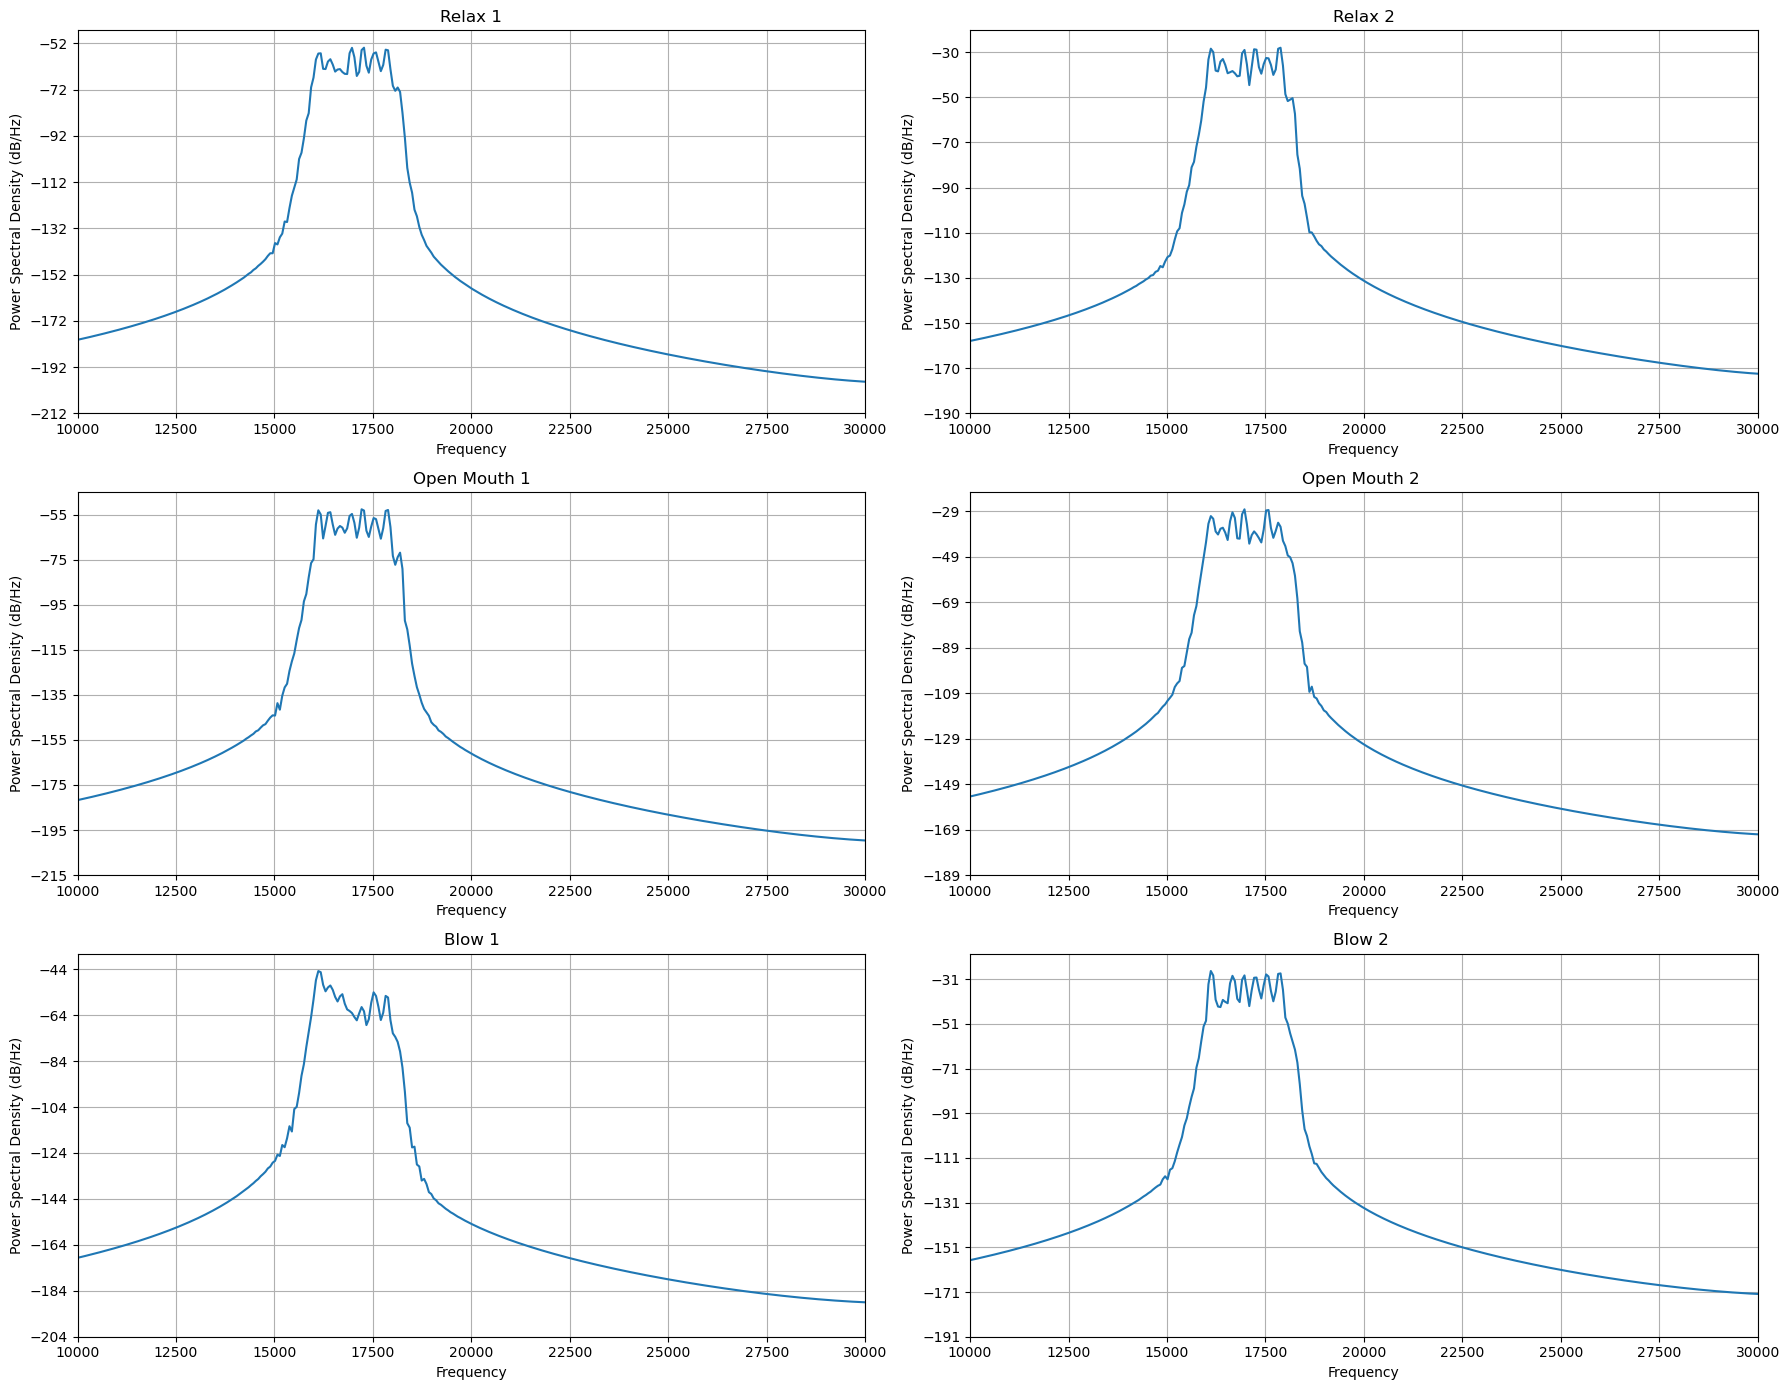

In [35]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 14))

# plot time signal:
axs[0, 0].set_title("Relax 1")
axs[0, 0].psd((avg_relax_wave_1),NFFT=1024,Fs=fs)
axs[0, 0].set_xlim((10000,30000))

# plot different spectrum types:
axs[0, 1].set_title("Relax 2")
axs[0, 1].psd((avg_relax_wave_2),NFFT=1024,Fs=fs)
axs[0, 1].set_xlim((10000,30000))

axs[1, 0].set_title("Open Mouth 1")
axs[1, 0].psd((avg_OpenMouth_wave_1),NFFT=1024,Fs=fs)
axs[1, 0].set_xlim((10000,30000))

axs[1, 1].set_title("Open Mouth 2 ")
axs[1, 1].psd((avg_OpenMouth_wave_2),NFFT=1024,Fs=fs)
axs[1,1].set_xlim((10000,30000))

axs[2, 0].set_title("Blow 1")
axs[2, 0].psd((avg_blow_wave_1-avg_clean_wave),NFFT=1024,Fs=fs)
axs[2, 0].set_xlim((10000,30000))

axs[2, 1].set_title("Blow 2 ")
axs[2, 1].psd((avg_blow_wave_2-avg_clean_wave),NFFT=1024,Fs=fs)
axs[2,1].set_xlim((10000,30000))

fig.tight_layout()
plt.show()

Zero Crossing Rate

In [36]:
print("# of zero Crossings while Relax = ",sum(librosa.zero_crossings(avg_relax_wave_1,pad=False)))
print("# of zero Crossings while Relax = ",sum(librosa.zero_crossings(avg_relax_wave_2,pad=False)))
print("# of zero Crossings while Open Mouth = ",sum(librosa.zero_crossings(avg_OpenMouth_wave_1,pad=False)))
print("# of zero Crossings while Open Mouth = ",sum(librosa.zero_crossings(avg_OpenMouth_wave_2,pad=False)))


# of zero Crossings while Relax =  6848
# of zero Crossings while Relax =  6896
# of zero Crossings while Open Mouth =  6830
# of zero Crossings while Open Mouth =  6872


Spectral Centroid

In [37]:
sc_Relax = librosa.feature.spectral_centroid(y=avg_relax_wave_1,sr=fs, n_fft=FRAME_SIZE,hop_length=Hop_Length)[0]
sc_OpenMouth = librosa.feature.spectral_centroid(y=avg_OpenMouth_wave_1,sr=fs, n_fft=FRAME_SIZE,hop_length=Hop_Length)[0]

frames = range(len(sc_OpenMouth))
t_sc = librosa.frames_to_samples(frames)*T

[]

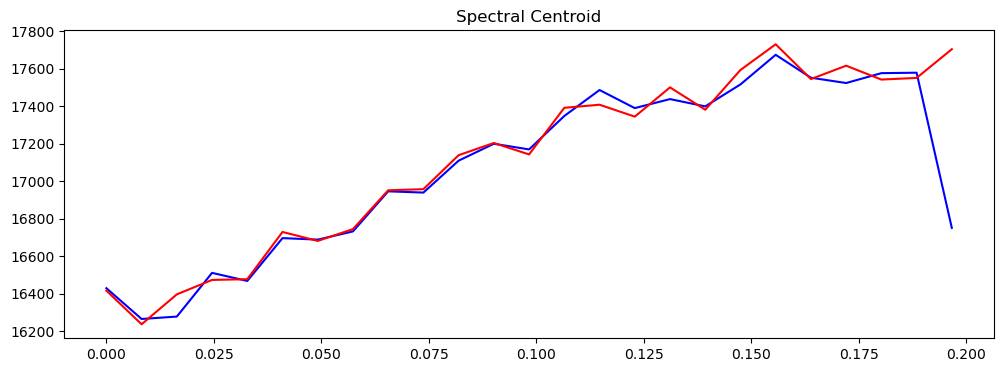

In [38]:
plt.figure(figsize=(12,4))
plt.plot(t_sc,sc_Relax,color="b")

plt.plot(t_sc,sc_OpenMouth,color="r")
plt.title("Spectral Centroid")

plt.plot()

Spectral roll off

In [39]:
sr_Relax_1 = librosa.feature.spectral_rolloff(y=avg_relax_wave_1,sr=fs, n_fft=FRAME_SIZE,hop_length=Hop_Length)[0]
sr_OpenMouth_1 = librosa.feature.spectral_rolloff(y=avg_OpenMouth_wave_1,sr=fs, n_fft=FRAME_SIZE,hop_length=Hop_Length)[0]
sr_Relax_2 = librosa.feature.spectral_rolloff(y=avg_relax_wave_2,sr=fs, n_fft=FRAME_SIZE,hop_length=Hop_Length)[0]
sr_OpenMouth_2 = librosa.feature.spectral_rolloff(y=avg_OpenMouth_wave_2,sr=fs, n_fft=FRAME_SIZE,hop_length=Hop_Length)[0]

frames = range(len(sr_OpenMouth_1))
t_sr = librosa.frames_to_samples(frames)*T

[]

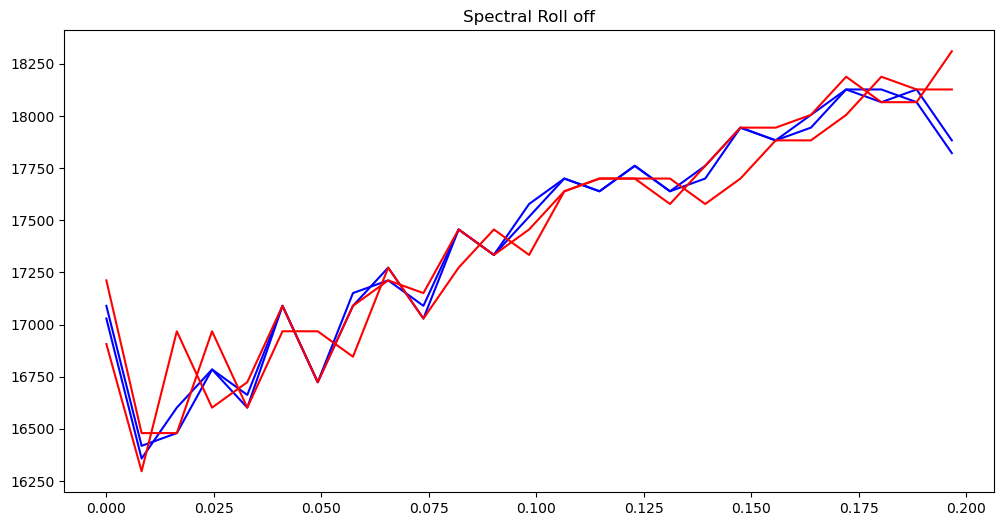

In [40]:
plt.figure(figsize=(12,6))
plt.plot(t_sr,sr_Relax_1,color="b")
plt.plot(t_sr,sr_Relax_2,color="b")
plt.plot(t_sr,sr_OpenMouth_1,color="r")
plt.plot(t_sr,sr_OpenMouth_2,color="r")
plt.title("Spectral Roll off")

plt.plot()

[]

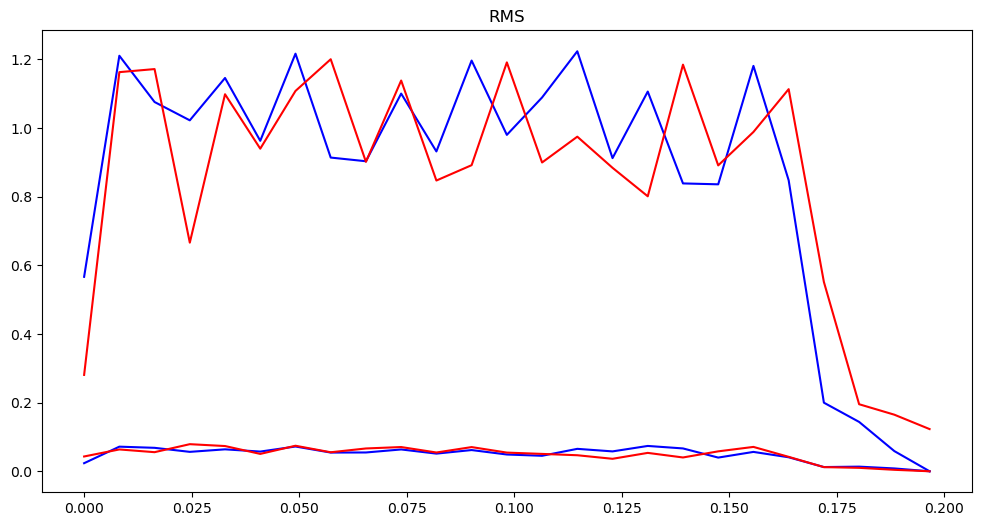

In [41]:
RMS_Relax_1 = librosa.feature.rms(y=avg_relax_wave_1, frame_length=FRAME_SIZE,hop_length=Hop_Length)[0]
RMS_Relax_2 = librosa.feature.rms(y=avg_relax_wave_2, frame_length=FRAME_SIZE,hop_length=Hop_Length)[0]
RMS_OpenMouth_1 = librosa.feature.rms(y=avg_OpenMouth_wave_1, frame_length=FRAME_SIZE,hop_length=Hop_Length)[0]
RMS_OpenMouth_2 = librosa.feature.rms(y=avg_OpenMouth_wave_2, frame_length=FRAME_SIZE,hop_length=Hop_Length)[0]

frames = range(len(RMS_OpenMouth_1))
t_RMS = librosa.frames_to_samples(frames)*T

plt.figure(figsize=(12,6))
plt.plot(t_RMS,RMS_Relax_1,color="blue")
plt.plot(t_RMS,RMS_Relax_2,color="blue")
plt.plot(t_RMS,RMS_OpenMouth_1,color="red")
plt.plot(t_RMS,RMS_OpenMouth_2,color="red")
plt.title("RMS")

plt.plot()